[View in Colaboratory](https://colab.research.google.com/github/taiki323/kaggle_training/blob/master/Google_Analytics_Customer_Revenue_Prediction.ipynb)

# 課題
- Google Merchandise Storeの顧客データを分析して、顧客あたりの収益を予測する。

- 各fullVisitorIdに対して、PredictedLogRevenueで総収入の自然対数を予測する。RMSEで評価

![target](https://github.com/taiki323/image_house/blob/master/target1.PNG?raw=true)

# セットアップ

In [99]:
!pip install kaggle　
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [100]:
# !mkdir .kaggle
!mkdir ~/.kaggle
%cd /content
!mkdir work
%cd work
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c ga-customer-revenue-prediction

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/content
mkdir: cannot create directory ‘work’: File exists
/content/work
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [101]:
!unzip '*.zip'

Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  test.csv.zip

Archive:  train.csv.zip

3 archives were successfully processed.


In [206]:
import pandas as pd
import numpy as np
import datetime
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

# 前処理

## データ確認
１回のストア訪問につき、１行のデータになる。

train:90万データ   
test: 80万データ
- fullVisitorId: 一意なユーザID
- channelGrouping: ユーザがストアにアクセスした経路(アフィリエイトなど)
- date: ストアに訪れた日付
- device: ユーザが使用したデバイス
- geoNetwork: ユーザがいる地域
- sessionId: セッションID
- socialEngagementType: Not Socially Engagedしかデータない
- totals: セッション全体の集計値
- trafficSource: トラフィックソースの情報
- visitId: セッションID。ユーザにのみ一意。
- visitNumber: セッション番号。初回アクセスなら1。
- visitStartTime: ストアに訪れた時間

In [0]:
#データ読み込み
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    for column in JSON_COLUMNS:
        df = df.join(pd.DataFrame(df.pop(column).apply(pd.io.json.loads).values.tolist(), index=df.index))

    return df
  
train = load_df("/content/work/train.csv")
test = load_df("/content/work/test.csv")

In [104]:
print(train.shape)
print(test.shape)
train.head()

(903653, 50)
(804684, 48)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,...,visits,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,1,NaN,{'criteriaParameters': 'not available in demo ...,(not set),NaN,True,(not provided),organic,NaN,google


In [105]:
#trainデータにあって、testデータに無いカラム
diff_col = list(set(train.columns) - set(test.columns))
print(diff_col)

['transactionRevenue', 'campaignCode']


## データクレイジング

### 不要なカラムの除去

In [106]:
#全て同じ値のカラムを削除
train['adwordsClickInfo'] = train['adwordsClickInfo'].astype(str)
test['adwordsClickInfo'] = test['adwordsClickInfo'].astype(str)
train = train.drop('campaignCode',axis=1)

for column in train.columns:
  if len(train[column].value_counts()) == 1:
    train = train.drop(column,axis=1)
    test = test.drop(column,axis=1)
    print(column)

socialEngagementType
browserSize
browserVersion
flashVersion
language
mobileDeviceBranding
mobileDeviceInfo
mobileDeviceMarketingName
mobileDeviceModel
mobileInputSelector
operatingSystemVersion
screenColors
screenResolution
cityId
latitude
longitude
networkLocation
bounces
newVisits
visits
isTrueDirect


In [107]:
#欠損値を確認
def kesson_table (df):
  null_val = df.isnull().sum()
  percent = (null_val / len(df)) * 100
  kesson_table = pd.concat([null_val, percent],axis=1)
  kesson_table_ren_columns = kesson_table.rename(columns={0:'欠損値', 1:'%'})
  return kesson_table_ren_columns

print(kesson_table(train))
print(kesson_table(test))

                       欠損値          %
channelGrouping          0   0.000000
date                     0   0.000000
fullVisitorId            0   0.000000
sessionId                0   0.000000
visitId                  0   0.000000
visitNumber              0   0.000000
visitStartTime           0   0.000000
browser                  0   0.000000
deviceCategory           0   0.000000
isMobile                 0   0.000000
operatingSystem          0   0.000000
city                     0   0.000000
continent                0   0.000000
country                  0   0.000000
metro                    0   0.000000
networkDomain            0   0.000000
region                   0   0.000000
subContinent             0   0.000000
hits                     0   0.000000
pageviews              100   0.011066
transactionRevenue  892138  98.725728
adContent           892707  98.788694
adwordsClickInfo         0   0.000000
campaign                 0   0.000000
keyword             502929  55.655102
medium      

In [0]:
#半分以上データが欠損しているカラムを削除
#transactionRevenueは目的変数なので削除しない
del_columns = ["referralPath","keyword", "adContent"]
train = train.drop(del_columns, axis=1)
test = test.drop(del_columns, axis=1)

In [0]:
#予測に関係のないデータを削除
unwanted = ["adwordsClickInfo"]
train = train.drop(unwanted, axis=1)
test = test.drop(unwanted, axis=1)

In [0]:
#transactionRevenueのNaNを0埋め
train['transactionRevenue'] = train['transactionRevenue'].fillna(0)

In [111]:
print(train.shape)
print(test.shape)
print(train.columns)

(903653, 24)
(804684, 23)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'browser', 'deviceCategory',
       'isMobile', 'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'hits', 'pageviews',
       'transactionRevenue', 'campaign', 'medium', 'source'],
      dtype='object')


## プロット

### transactionRevenueの散布図
お金を払っているユーザの割合


お金を払っているユーザの割合は全体の 1.399672625590373 %


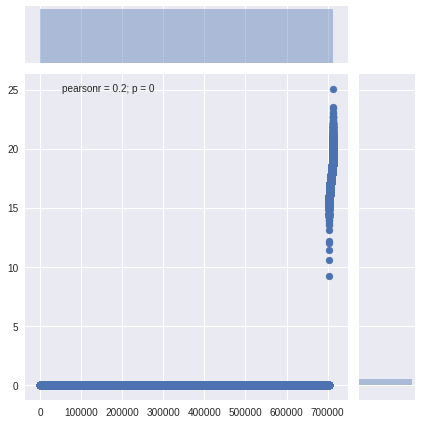

In [112]:
#fullVisitorIdのグループ毎にtransactionRevenueの合計算出
train['transactionRevenue'] = train['transactionRevenue'].astype(float)
gdf = train.groupby('fullVisitorId')['transactionRevenue'].sum().reset_index()
gdf = gdf.sort_values('transactionRevenue')
sns.jointplot(np.arange(gdf.shape[0]),np.log1p(gdf['transactionRevenue'].values))
print("お金を払っているユーザの割合は全体の" ,100 * ((gdf['transactionRevenue']>0).sum()) / gdf.shape[0], "%")

In [0]:
#日付の型をdatetimeに変換
train['date'] = train['date'].apply(lambda x : datetime.date(int(str(x)[0:4]),int(str(x)[4:6]),int(str(x)[6:8])))

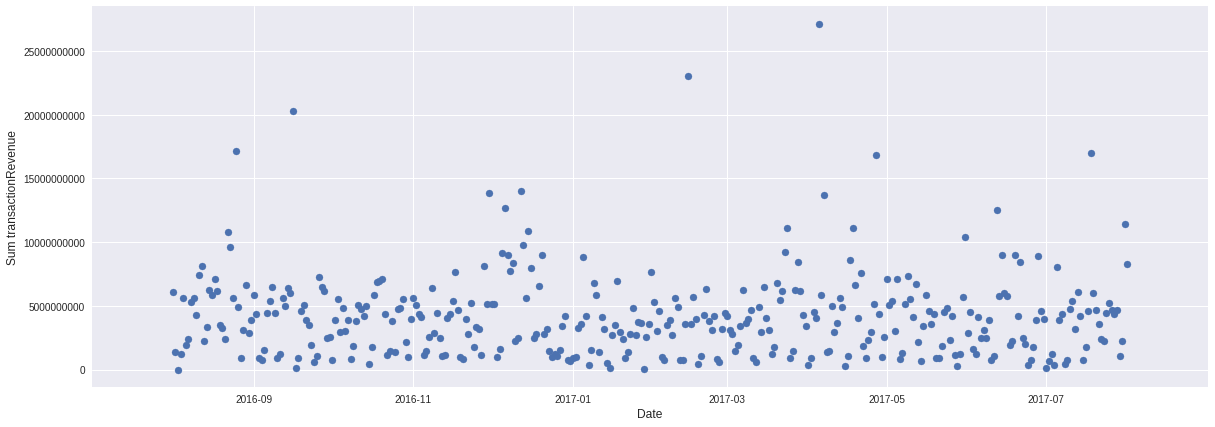

In [244]:
dateRev = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(dateRev.index.values, dateRev['sum'])
plt.show()

### 棒グラフ

In [0]:
#新しい列追加　
train['Revenue'] = None
train['Revenue'][train['transactionRevenue'] == 0] = 'zero'
train['Revenue'][train['transactionRevenue'] > 0] = 'non-zero'

In [0]:
#データ数少ない要素をまとめる
select_browser = ['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge', 'Android Webview', 'Safari (in-app)', 'Opera Mini', 'Opera']
del_browser = set(train['browser'].unique()) -  set(select_browser)
for br in del_browser:
  train['browser'] = train['browser'].replace(br, 'Others')

select_os = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS']
del_os = set(train['operatingSystem'].unique()) -  set(select_os)
for br in del_os:
  train['operatingSystem'] = train['operatingSystem'].replace(br, 'Others')

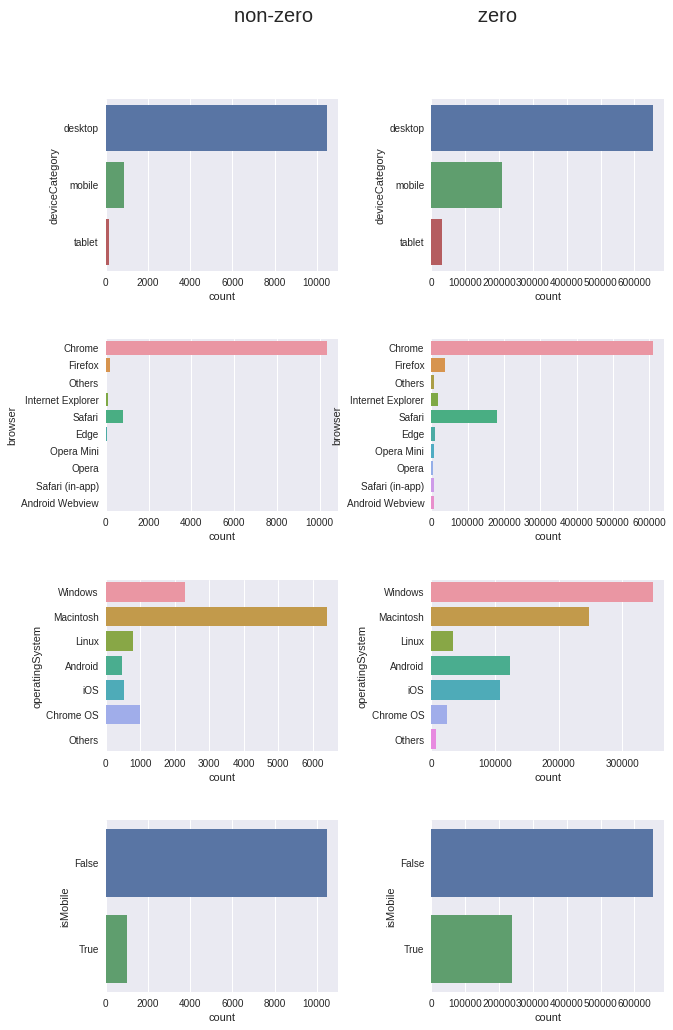

In [199]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,16))
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
sns.plt.suptitle('non-zero                              zero', fontsize=20)
sns.countplot(y='deviceCategory', data=train[train['Revenue'] == 'non-zero'],order=train['deviceCategory'].unique(), ax = axes[0][0])
sns.countplot(y='deviceCategory', data=train[train['Revenue'] == 'zero'], order=train['deviceCategory'].unique(), ax = axes[0][1])
sns.countplot(y='browser', data=train[train['Revenue'] == 'non-zero'], order=train['browser'].unique(), ax = axes[1][0])
sns.countplot(y='browser', data=train[train['Revenue'] == 'zero'],order=train['browser'].unique(), ax = axes[1][1])
sns.countplot(y='operatingSystem', data=train[train['Revenue'] == 'non-zero'], order=train['operatingSystem'].unique(), ax = axes[2][0])
sns.countplot(y='operatingSystem', data=train[train['Revenue'] == 'zero'], order=train['operatingSystem'].unique(), ax = axes[2][1])
sns.countplot(y='isMobile', data=train[train['Revenue'] == 'non-zero'], order=train['isMobile'].unique(), ax = axes[3][0])
sns.countplot(y='isMobile', data=train[train['Revenue'] == 'zero'], order=train['isMobile'].unique(),ax = axes[3][1])

- deviceCategoryはnon-zeroの方がデスクトップの割合高い   
- browserはzeroの方がSafariの割合高い   
- operatingSystemはnon-zeroがWindowsよりもMacintosh使用率高い
- non-zeroはChrome OSの使用率も高い
- non-zeroはモバイルOSの割合が低い

### 折れ線グラフ

In [210]:
train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])

,count,sum
date,,
20160801,1711,6.116060e+09
20160802,2140,1.361190e+09
20160803,2890,0.000000e+00
20160804,3161,1.182890e+09
20160805,2702,5.594260e+09
20160806,1663,1.891040e+09
20160807,1622,2.410730e+09
20160808,2815,5.273810e+09
20160809,2851,5.596400e+09
